# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import CIFAR10, FakeData
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn import metrics

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [53]:
# Define the transforms for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 train dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
# Split the train dataset into train and validation datasets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
ds_train, ds_val = torch.utils.data.random_split(trainset, [train_size, val_size])

# Load the CIFAR10 test dataset
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load OOD data
ds_fake = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
# Training hyperparameters.
epochs = 50
lr = 0.0001
batch_size = 256

# Create the train, val, and test dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=8)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=8)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=8)

# Create data loader for fake data
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=False, num_workers=8)

# Instantiate model and optimizer.
model = Net().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dl_train):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch: {epoch}, Loss: {running_loss / len(dl_train)}')

In [56]:
# USE THIS CELL FOR LOAD THE PRETRAINED MODEL
model = Net().to(device)
model.load_state_dict(torch.load("./cifar10_CNN.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [57]:
model.eval()
labels, preds = [], []
for i, (input, label) in enumerate(dl_test):
    input, label = input.to(device), label.to(device)
    output = model(input)

    preds.append(output.argmax(1))
    labels.append(label)


Accuracy: 0.6029000282287598


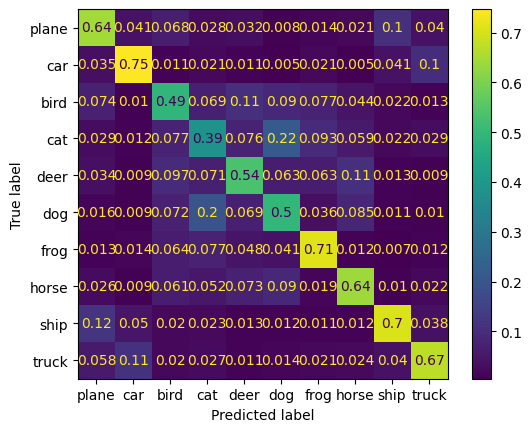

In [58]:
preds_t = torch.cat(preds)
labels_t = torch.cat(labels)

accuracy = sum(preds_t == labels_t) / len(labels_t)
print(f"Accuracy: {accuracy}")

cm = metrics.confusion_matrix(labels_t.cpu(), preds_t.cpu())
cmn = cm.astype(np.float32)
cmn /= cmn.sum(1)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=classes)
disp.plot()
plt.show()


In [59]:
def max_logit(logit):
  return logit.max(dim=1)[0]

def max_softmax(logit, T=1):
    s = F.softmax(logit/T, 1)
    return s.max(dim=1)[0]

def compute_score(dataloader, score_fun):
    scores = []
    for x, y in dataloader:
        output = model(x.to(device))
        s = score_fun(output)
        scores.append(s)
    scores_t = torch.cat(scores)
    return scores_t


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


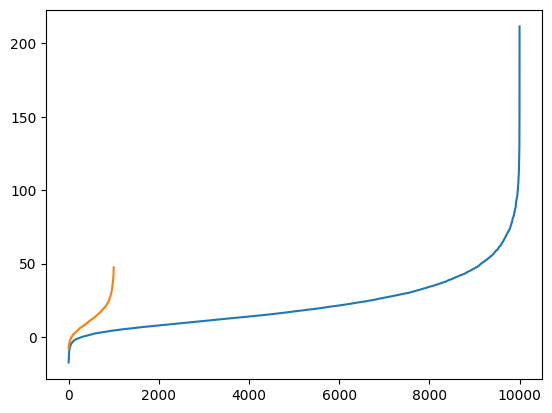

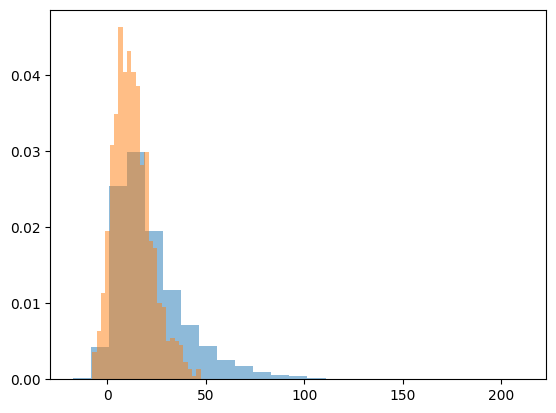

In [60]:
scores_test = compute_score(dl_test, max_logit)
scores_fake = compute_score(dl_fake, max_logit)

plt.figure()
plt.plot(sorted(scores_test.detach().cpu()))
plt.plot(sorted(scores_fake.detach().cpu()))

plt.figure()
_ = plt.hist(scores_test.detach().cpu(), density=True, alpha=0.5, bins=25)
_ = plt.hist(scores_fake.detach().cpu(), density=True, alpha=0.5, bins=25)


### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


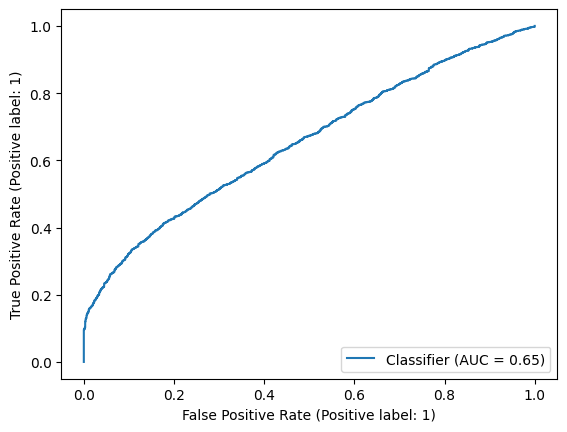

In [61]:
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)
y = torch.cat((y_test, y_fake))
metrics.RocCurveDisplay.from_predictions(y.detach().cpu(), ypred.detach().cpu())


---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [ ]:
# Your code here.

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
# Your code here.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
